In [ ]:
!pip install -q pyomo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc  # Install CBC
!conda install -c conda-forge pyomo coincbc


Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [ ]:
from pyomo.environ import ConcreteModel, Var, Constraint, Binary, SolverFactory, ConstraintList, Objective, maximize

# Parameters
m = 9  # number of rows in the grid
n = 9  # number of columns in the grid
colors = ['gray', 'aqua', 'yellow', 'royalblue', 'purple', 'deeppink']  # list of available colors

# Create a model
model = ConcreteModel()

# Define sets for rows, columns, and colors
model.rows = range(m)
model.cols = range(n)
model.colors = colors

# Define binary variables X_ijc: 1 if cell (i, j) is colored with color c, else 0
model.X = Var(model.rows, model.cols, model.colors, domain=Binary)


# Fix some variables as required (for example, set cell (1,2) to "red")
root_cells = {
    (4, 1): 'gray', (1, 2): 'gray',
    (4, 3): 'yellow', (7, 7): 'yellow',
    (2, 2): 'aqua', (6, 1): 'aqua',
    (7, 1): 'purple', (4, 4): 'purple',
    (3, 4): 'royalblue', (7, 3): 'royalblue',
    (6, 4): 'deeppink', (3, 5): 'deeppink'
}  # specify cells and their fixed colors

for (i, j), color in root_cells.items():
    model.X[i, j, color].fix(1)  # Fix the specified color to 1 for the given cell
    for other_color in colors:
        if other_color != color:
            model.X[i, j, other_color].fix(0)

# Fixing borders
for i in range(m):
    for color in colors:
        model.X[i, 0, color].fix(0)
        model.X[i, n - 1, color].fix(0)
for i in range(n):
    for color in colors:
        model.X[0, i, color].fix(0)
        model.X[m - 1, i, color].fix(0)

# Coverage constraint: each cell (i, j) must have at last one color
def coverage_constraint(model, i, j):
    return sum(model.X[i, j, c] for c in model.colors) <= 1
model.coverage_constraints = Constraint(model.rows, model.cols, rule=coverage_constraint)

# Neighbor constraint for root cells
def root_cells_neighbor_constraint(model, i, j, c):
    constraints = []
    if i > 0:        # cell (i-1, j) exists
        constraints.append(model.X[i - 1, j, c])
    if i < m - 1:    # cell (i+1, j) exists
        constraints.append(model.X[i + 1, j, c])
    if j > 0:        # cell (i, j-1) exists
        constraints.append(model.X[i, j - 1, c])
    if j < n - 1:    # cell (i, j+1) exists
        constraints.append(model.X[i, j + 1, c])

    # Ensure that exactly one neighboring cell has the same color
    return sum(constraints) == 1

# Add the neighbor constraint for each root cell's color
model.root_cells_neighbor_constraints = ConstraintList()
for (i, j), color in root_cells.items():
    model.root_cells_neighbor_constraints.add(root_cells_neighbor_constraint(model, i, j, color))


model.all_cells_neighbor_constraints = ConstraintList()

def add_all_cells_neighbor_constraint(model, i, j, c):
    neighbors = []
    if i > 0:        # cell (i-1, j) exists
        neighbors.append(model.X[i - 1, j, c])
    if i < m - 1:    # cell (i+1, j) exists
        neighbors.append(model.X[i + 1, j, c])
    if j > 0:        # cell (i, j-1) exists
        neighbors.append(model.X[i, j - 1, c])
    if j < n - 1:    # cell (i, j+1) exists
        neighbors.append(model.X[i, j + 1, c])

    # Upper bound constraint
    model.all_cells_neighbor_constraints.add(sum(neighbors) <= 2 + 2 - 2 * model.X[i, j, c])

    # Lower bound constraint
    model.all_cells_neighbor_constraints.add(sum(neighbors) >= 2 - 2 + 2 * model.X[i, j, c])

# Add the neighbor constraints for each cell and color
for i in model.rows:
    for j in model.cols:
        if (i, j) not in root_cells:
            for c in model.colors:
                add_all_cells_neighbor_constraint(model, i, j, c)


model.objective = Objective(expr=sum(model.X[i, j, c] for i in model.rows for j in model.cols for c in model.colors), sense=maximize)

# Solve the model
solver = SolverFactory('glpk')  # Change to your solver of choice
solver.solve(model)

# Display the solution
grid = {}
print("Solution:")
for c in model.colors:
    for i in model.rows:
        for j in model.cols:
            if model.X[i, j, c]() == 1:
                grid[(i,j)] = c


Solution:


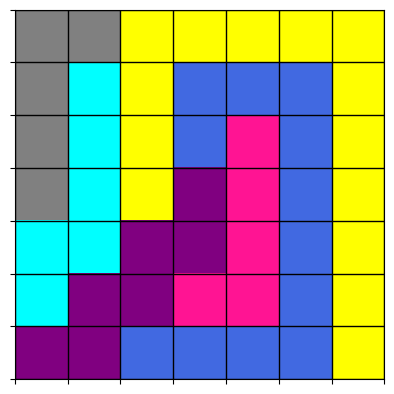

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

# Determine grid size based on the maximum row and column indices
max_row = max(key[0] for key in grid)
max_col = max(key[1] for key in grid)

# Initialize a grid to hold the RGB colors
color_grid = np.ones((max_row, max_col, 3))  # Initialize with white background (1,1,1)

# Populate the color grid
for (i, j), color in grid.items():
    color_grid[i-1, j-1] = colors.to_rgb(color)  # Convert color name to RGB, offset for 0-indexing

# Plot the grid
fig, ax = plt.subplots()
ax.imshow(color_grid, interpolation='none')

# Customize grid lines
ax.set_xticks(np.arange(-0.5, max_col, 1))
ax.set_yticks(np.arange(-0.5, max_row, 1))
ax.grid(which='both', color='black', linestyle='-', linewidth=2)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()